## Use Keras embedding layer and LSTM Model to train the classifier

### Dataset used : ag-news 

https://huggingface.co/datasets/ag_news 

In [3]:
!pip install datasets

     |████████████████████████████████| 264 kB 7.6 MB/s 
     |████████████████████████████████| 243 kB 56.9 MB/s 
     |████████████████████████████████| 76 kB 5.8 MB/s 
     |████████████████████████████████| 43 kB 2.2 MB/s 
     |████████████████████████████████| 118 kB 65.9 MB/s 
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.41.1
    Uninstalling tqdm-4.41.1:
      Successfully uninstalled tqdm-4.41.1


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

import nltk
nltk.download('book')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
import re

lemmatizer = WordNetLemmatizer()
# stemmer = PorterStemmer()
stop = stopwords.words('english')

from datasets import load_dataset

import tensorflow as tf
# import tensorflow_hub as hub 

from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, Flatten, LSTM, Bidirectional

%matplotlib inline

[nltk_data] Downloading collection 'book'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package brown to /root/nltk_data...
[nltk_data]    |   Package brown is already up-to-date!
[nltk_data]    | Downloading package chat80 to /root/nltk_data...
[nltk_data]    |   Package chat80 is already up-to-date!
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package conll2000 to /root/nltk_data...
[nltk_data]    |   Package conll2000 is already up-to-date!
[nltk_data]    | Downloading package conll2002 to /root/nltk_data...
[nltk_data]    |   Package conll2002 is already up-to-date!
[nltk_data]    | Downloading package dependency_treebank to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package dependency_treebank is already up-to-date!
[nltk_data]    | Downloadi

In [5]:
print(tf.__version__)
# print(hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

2.5.0
GPU is available


In [6]:
dataset = load_dataset("ag_news")

train_set = dataset["train"].to_pandas()
X_train_text = train_set["text"]
y_train_labels = train_set["label"]

test_set = dataset["test"].to_pandas()
X_test_text = test_set["text"]
y_test_labels = test_set["label"]

print(f"X_test_text : {len(X_test_text)}")
print(f"y_test_labels : {len(y_test_labels)}")

num_classes = dataset["train"].features['label'].num_classes
class_labels = dataset["train"].features['label'].names

print(f"Number of classes : {num_classes}, Class Labels :{class_labels}")

assert dataset["train"].features['label'].num_classes == dataset["test"].features['label'].num_classes
assert dataset["train"].features['label'].names == dataset["test"].features['label'].names

Downloading:   0%|          | 0.00/1.83k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.28k [00:00<?, ?B/s]

Using custom data configuration default


Downloading:   0%|          | 0.00/11.0M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/751k [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset ag_news downloaded and prepared to /root/.cache/huggingface/datasets/ag_news/default/0.0.0/bc2bcb40336ace1a0374767fc29bb0296cdaf8a6da7298436239c54d79180548. Subsequent calls will reuse this data.
X_test_text : 7600
y_test_labels : 7600
Number of classes : 4, Class Labels :['World', 'Sports', 'Business', 'Sci/Tech']


In [7]:
print(X_test_text[0], y_test_labels[0])

Fears for T N pension after talks Unions representing workers at Turner   Newall say they are 'disappointed' after talks with stricken parent firm Federal Mogul. 2


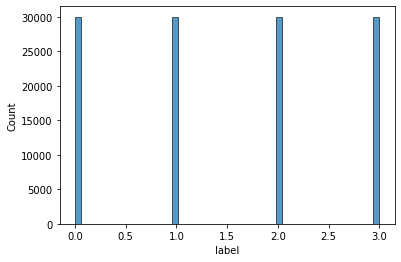

In [8]:
sns.histplot(y_train_labels)

### Label Encoding

In [9]:
# Convert labels to one-hot vectors
y_train = tf.keras.utils.to_categorical(y_train_labels, num_classes=num_classes)
y_test = tf.keras.utils.to_categorical(y_test_labels, num_classes=num_classes)
print(y_train.shape, y_test.shape)

(120000, 4) (7600, 4)


### Text Preprocessing

In [11]:
def clean_text(text):
    text = text.lower()
    # remove non-alphanumeric characters
    text = re.sub(r'\W+', ' ', text)
    # remove all digits
    text = re.sub(r'\d+', ' ', text)
    # remove all white space
    text = re.sub(r'\s+', ' ', text)

    words = text.split()
    words = [ lemmatizer.lemmatize(w) for w in words if len(w) >= 2]

    return ' '.join(words)

print(X_train_text[0])
print(clean_text(X_train_text[0]))


Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.
wall st bear claw back into the black reuters reuters short seller wall street dwindling band of ultra cynic are seeing green again


In [12]:
X_train_text_cleaned = X_train_text.apply(clean_text)
X_test_text_cleaned = X_test_text.apply(clean_text)

#### Now Identify key words using tfidf vectorizer

In [27]:
vectorizer = TfidfVectorizer(max_df=0.6, max_features=14998, min_df=5, ngram_range=(1,1))
vectorizer.fit(X_train_text_cleaned)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=0.6, max_features=14998,
                min_df=5, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [28]:
vocab = vectorizer.vocabulary_
print(type(vocab), len(vocab))

<class 'dict'> 14998


In [29]:
list(vocab.items())[1000:1005]

[('information', 6634),
 ('boy', 1657),
 ('anyway', 610),
 ('though', 13479),
 ('founder', 5186)]

In [30]:
indices = sorted(list(vocab.values()))
indices[:10] , indices[-10:]

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [14988, 14989, 14990, 14991, 14992, 14993, 14994, 14995, 14996, 14997])

In [33]:
def map_tokens(text):
    words = text.split()
    tokens = np.array([vocab.get(w,14998) for w in words])
    return tokens

X_train_tokens = X_train_text_cleaned.apply(map_tokens)
X_test_tokens = X_test_text_cleaned.apply(map_tokens)
print(X_train_tokens.shape, X_test_tokens.shape)

(120000,) (7600,)


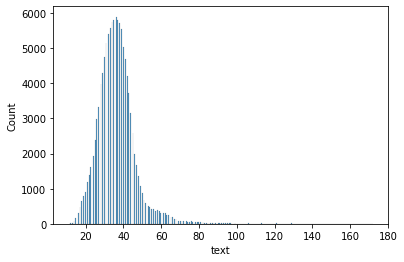

In [34]:
sns.histplot(X_train_tokens.map(len))

In [35]:
# Now pad sequences 
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train_tokens, maxlen=60, padding="post", value=14999)
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test_tokens, maxlen=60, padding="post", value=14999)

print(X_train.shape, X_test.shape)

(120000, 60) (7600, 60)


In [38]:
# count number of unknowns 
unk = np.sum(X_train==14998)
pad = np.sum(X_train==14999)

print(f"Num of unk : {unk} {unk/(1200*60):.3f} %, pad : {pad} {pad/(1200*60):.3f} %" )

Num of unk : 482347 6.699 %, pad : 2861145 39.738 %


## Create Model

In [40]:
def create_lstm_model_with_word_embedding(n_classes):
    tf.keras.backend.clear_session()

    """
    PARAMETERS OF THE EMBEDDING LAYER ---

    'input_dim' = the vocab size that we will choose. In other words it is the number of unique words in the vocab.
    'output_dim' = the number of dimensions we wish to embed into. Each word will be represented by a vector of this much dimensions.
    'input_length' = lenght of the maximum document. which is stored in maxlen variable in our case.
    """ 

    model = Sequential([
        Embedding(input_dim=15000, output_dim=50, input_length=60),
        LSTM(50, return_sequences=True),
        LSTM(50, return_sequences=False),
        Dense(n_classes, activation="softmax")
    ])

    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer="adam")
    model.summary()

    return model


model = create_lstm_model_with_word_embedding(num_classes)


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 60, 50)            750000    
_________________________________________________________________
lstm (LSTM)                  (None, 60, 50)            20200     
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 4)                 204       
Total params: 790,604
Trainable params: 790,604
Non-trainable params: 0
_________________________________________________________________


In [41]:
hist = model.fit(X_train, y_train, batch_size=32, epochs=10, verbose=1, validation_data=(X_test, y_test))

Epoch 1/10
3750/3750 [==============================] - 72s 17ms/step - loss: 0.4749 - accuracy: 0.8151 - val_loss: 0.3009 - val_accuracy: 0.9070
Epoch 2/10
3750/3750 [==============================] - 62s 16ms/step - loss: 0.2606 - accuracy: 0.9188 - val_loss: 0.2822 - val_accuracy: 0.9096
Epoch 3/10
3750/3750 [==============================] - 62s 16ms/step - loss: 0.2156 - accuracy: 0.9319 - val_loss: 0.2517 - val_accuracy: 0.9147
Epoch 4/10
3750/3750 [==============================] - 63s 17ms/step - loss: 0.1786 - accuracy: 0.9424 - val_loss: 0.2521 - val_accuracy: 0.9184
Epoch 5/10
3750/3750 [==============================] - 62s 17ms/step - loss: 0.1496 - accuracy: 0.9506 - val_loss: 0.2737 - val_accuracy: 0.9141
Epoch 6/10
3750/3750 [==============================] - 62s 17ms/step - loss: 0.1226 - accuracy: 0.9589 - val_loss: 0.3000 - val_accuracy: 0.9086
Epoch 7/10
3750/3750 [==============================] - 61s 16ms/step - loss: 0.0998 - accuracy: 0.9659 - val_loss: 0.3163 -

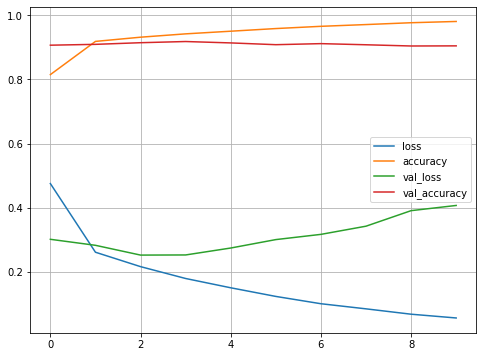

In [42]:
hdf = pd.DataFrame(hist.history)
hdf.plot(grid=True, figsize=(8, 6))

### Explore the cases for which it's not working

In [43]:
from sklearn.metrics import classification_report, plot_confusion_matrix, confusion_matrix

In [44]:
pred = model.predict(X_test)
pred_classes = np.argmax(pred, axis=-1)

In [45]:
print(classification_report(y_test_labels, pred_classes))
print(confusion_matrix(y_test_labels, pred_classes))

              precision    recall  f1-score   support

           0       0.92      0.91      0.91      1900
           1       0.96      0.97      0.97      1900
           2       0.86      0.87      0.87      1900
           3       0.87      0.87      0.87      1900

    accuracy                           0.90      7600
   macro avg       0.90      0.90      0.90      7600
weighted avg       0.90      0.90      0.90      7600

[[1722   44   78   56]
 [  22 1849   16   13]
 [  67   13 1651  169]
 [  68   11  166 1655]]


In [46]:
mis_match = pred_classes != y_test_labels

i = 0
for text, pred_class, actual_class in zip(X_test_text[mis_match], pred_classes[mis_match], y_test_labels[mis_match]):
    i += 1
    print(f"{i} - Text \t: {text}")
    print(f"Predicted Class : {pred_class} {class_labels[int(pred_class)]}")
    print(f"Actuall Class \t: {actual_class} {class_labels[int(actual_class)]}")

    if i >= 10:
        break

1 - Text 	: Prediction Unit Helps Forecast Wildfires (AP) AP - It's barely dawn when Mike Fitzpatrick starts his shift with a blur of colorful maps, figures and endless charts, but already he knows what the day will bring. Lightning will strike in places he expects. Winds will pick up, moist places will dry and flames will roar.
Predicted Class : 1 Sports
Actuall Class 	: 3 Sci/Tech
2 - Text 	: Open Letter Against British Copyright Indoctrination in Schools The British Department for Education and Skills (DfES) recently launched a "Music Manifesto" campaign, with the ostensible intention of educating the next generation of British musicians. Unfortunately, they also teamed up with the music industry (EMI, and various artists) to make this popular. EMI has apparently negotiated their end well, so that children in our schools will now be indoctrinated about the illegality of downloading music.The ignorance and audacity of this got to me a little, so I wrote an open letter to the DfES abo